In [1]:
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor

sns.set_theme(style="darkgrid")

import utils.utils as utils
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
from utils.utils_models import ForecastingModel

In [2]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)

In [3]:
df_kaggle = utils_preprocessing.preprocess_columns(df_kaggle)

In [4]:
# Resample weekly for each sku
# utils.looks_for_missing_dates(df_kaggle)
df_kaggle = utils_preprocessing.fill_in_missing_dates(df_kaggle)

# Interpolation and fill-in function
def interpolate_sku(group):
    group = group.sort_values(by='date')
    group = group.set_index('date')  
    group['sales_units'] = group['sales_units'].interpolate(method='time')
    group['inventory_units'] = group['inventory_units'].interpolate(method='time')
    return group.reset_index()

df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(interpolate_sku)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_preprocessing.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_ranges = df.groupby(group_col)[date_col].agg(['min', 'max']).reset_index()
/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_42840/3060182721.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(interpolate_sku)


In [5]:
# Generate features
df_kaggle = utils_features.features_time_related(df_kaggle)
df_kaggle = utils_features.features_lag(df=df_kaggle, col='inventory_units', lags=[13])
df_kaggle = utils_features.features_lag(df=df_kaggle, col='sales_units', lags=[13, 14, 15])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='sales_units', window_sizes=[4, 8])

In [6]:
df = df_kaggle.copy().rename(columns={'inventory_units': 'y'}).set_index('date').sort_index()

# df = df[df['segment'] == 'Premium'].rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date')

X_train = df.drop(columns=['y'])
y_train = df[["y"]]

In [7]:
lgb_params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': np.float64(0.9914924607394691),
    'importance_type': 'split',
    'learning_rate': np.float64(0.027590738215604697),
    'max_depth': np.int64(10),
    'min_child_samples': 25,
    'min_child_weight': 0.034,
    'min_split_gain': 0.0,
    'n_estimators': 1000,
    'n_jobs': None,
    'num_leaves': 157,
    'objective': 'regression',
    'random_state': 222,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'subsample': np.float64(0.6006545748134953),
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'bagging_fraction': 0.418,
    'bagging_seed': 11,
    'feature_fraction': 0.379,
    'metric': 'rmse',
    'min_data_in_leaf': 106,
    'verbosity': -1,
    }

In [8]:
fc_model = ForecastingModel(hyperparameters=lgb_params)
results_cv = fc_model.cross_validate2(df, n_splits=2)


Model evaluation completed. RMSE: 55.025
Model evaluation completed. RMSE: 55.261
Average RMSE from cross-validation: 55.1430


In [32]:
def select_last_n_weeks_from_df(df, n_weeks):
    time_index = df.index
    time_mask = time_index > time_index.max() - np.timedelta64(n_weeks, "W")
    return df.loc[time_mask]

def predict_last_13_weeks(df):
    df_last_13_weeks = select_last_n_weeks_from_df(df, n_weeks=13)
    X_test, y_test = df_last_13_weeks.drop(columns=['y']), df_last_13_weeks['y']
    y_preds = fc_model.model.predict(X=X_test)
    df_preds = pd.DataFrame(
        data={
            "sku": X_test["sku"],
            "y_pred": y_preds,
            #"y": y_test.values
        },
        index=X_test.index
    )
    return df_preds

In [9]:
df_preds = utils.predict_last_13_weeks(df, fc_model.model)
df_final = df.merge(df_preds.reset_index(), on=['date', 'sku'], how='left')

NameError: name 'np' is not defined

In [37]:
num_select = 4
list_skus = np.random.choice(df_preds['sku'].unique(), size=num_select, replace=False) # Random
#list_skus = X_test["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
#list_skus = X_test["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

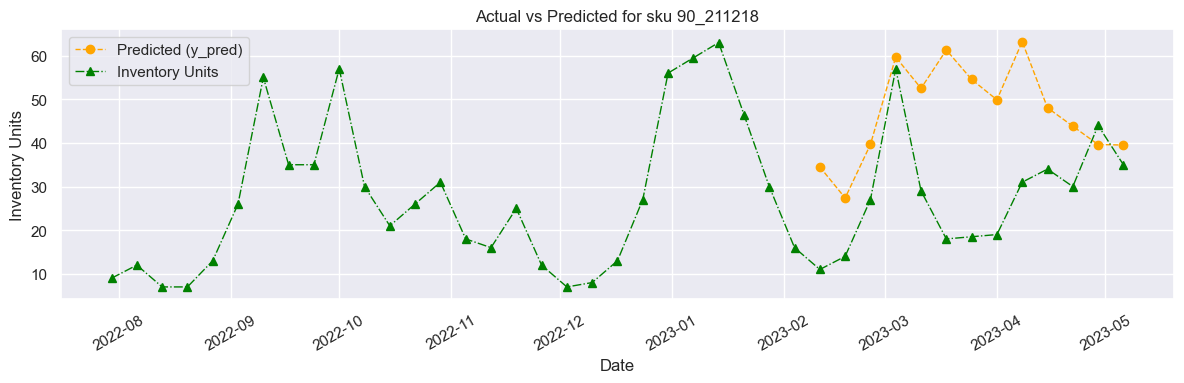

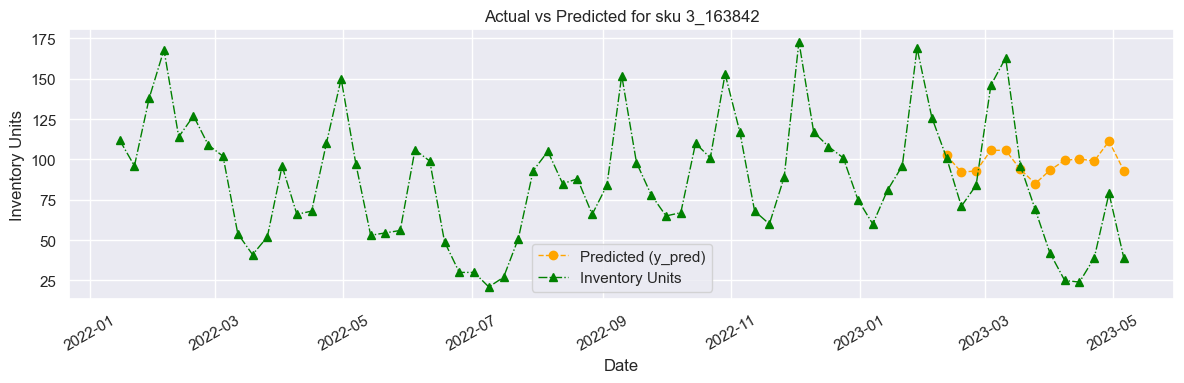

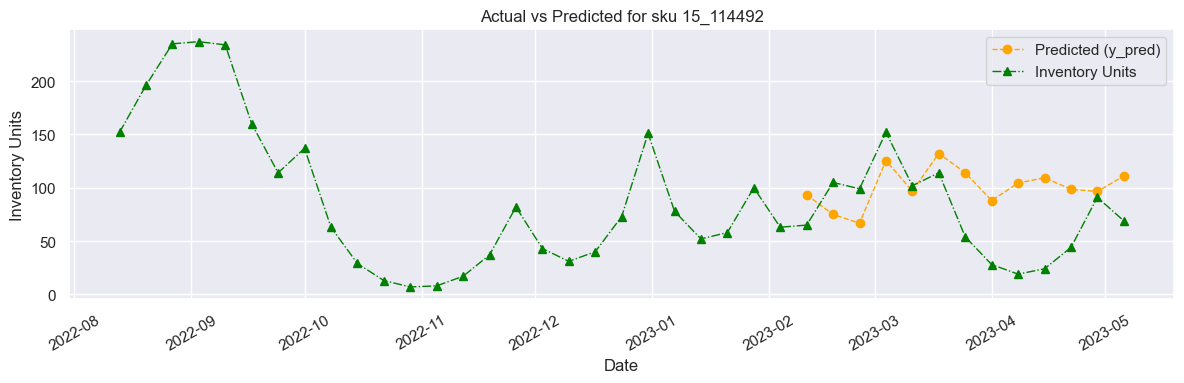

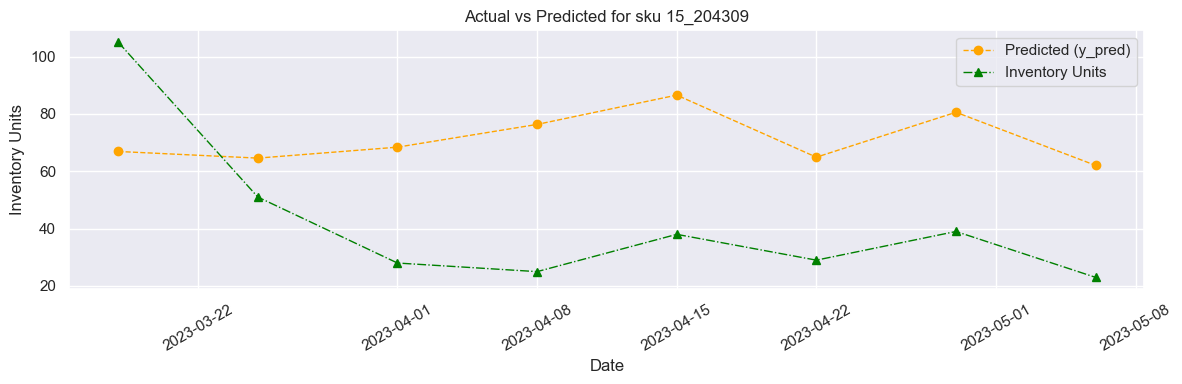

In [38]:
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_final, sku)

In [63]:
model = LGBMRegressor(**lgb_params)
model.fit(X=X_train, y=y_train)

LGBMRegressor(bagging_fraction=0.418, bagging_seed=11,
              colsample_bytree=np.float64(0.9914924607394691),
              feature_fraction=0.379,
              learning_rate=np.float64(0.027590738215604697),
              max_depth=np.int64(10), metric='rmse', min_child_samples=25,
              min_child_weight=0.034, min_data_in_leaf=106, n_estimators=1000,
              num_leaves=157, objective='regression', random_state=222,
              reg_alpha=0, reg_lambda=0,
              subsample=np.float64(0.6006545748134953), verbosity=-1)

In [64]:
time_index = X_train.index.get_level_values(-1)
time_mask = time_index > time_index.max() - np.timedelta64(13, "W")
X_train_recent = X_train.loc[time_mask]
y_train_recent = y_train.loc[time_mask]

In [65]:
y_pred_train = model.predict(X=X_train_recent)

df_preds = pd.DataFrame(
    data={
        "sku": X_train_recent["sku"],
        "y_pred": y_pred_train,
        "y": y_train_recent['y']
    },
    index=X_train_recent.index
)

In [66]:
num_select = 4
# list_skus = np.random.choice(df_preds['sku'].unique(), size=num_select, replace=False) # Random
list_skus = X_train_recent["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
# list_skus = X_test["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

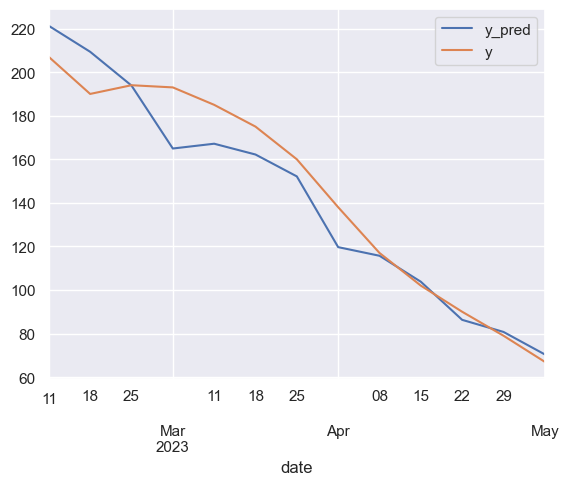

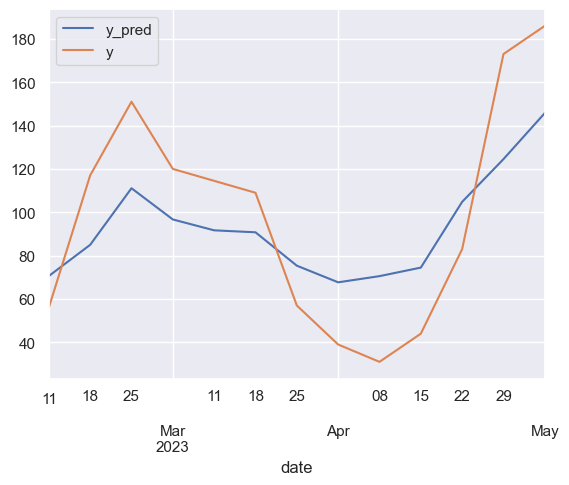

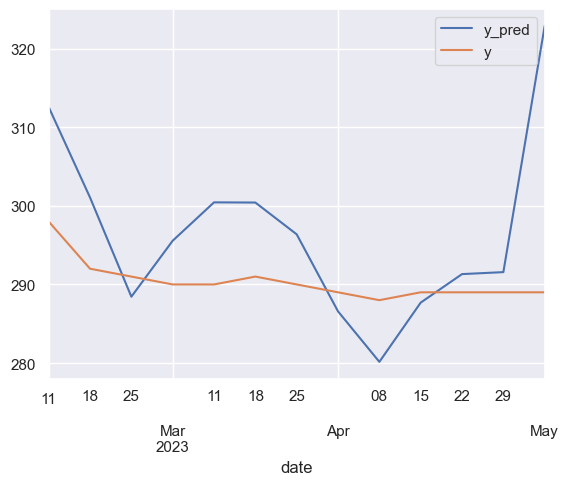

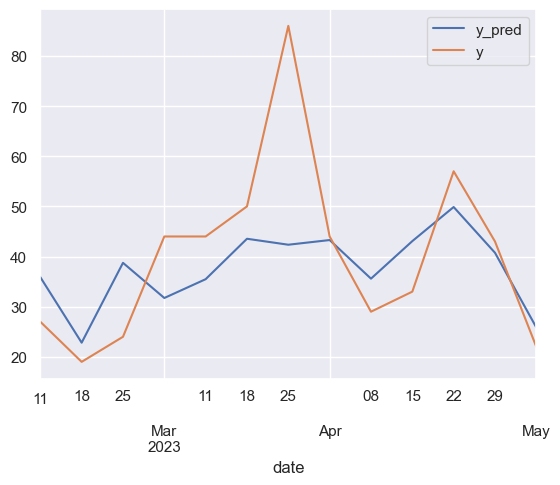

In [67]:
for sku in list_skus:
    temp = df_preds[df_preds['sku'] == sku]
    temp[['y_pred',	'y']].plot()

In [32]:
import scipy

In [61]:
np.append(-1, np.arange(3, 16))

array([-1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [68]:
param_distributions = {
    "learning_rate": scipy.stats.uniform(loc=0.003, scale=0.19),  # Default is 0.1. Ranges from loc to loc+scale.
    "num_leaves": scipy.stats.randint(8, 256),  # Default is 31
    "max_depth": np.append(-1, np.arange(3, 16)),  # Default is -1
    "min_child_samples": scipy.stats.randint(5, 300),  # Default is 20. AKA min_data_in_leaf.
    "subsample": scipy.stats.uniform(loc=0.5, scale=0.5),  # Default is 1. AKA bagging_fraction.
    "colsample_bytree": scipy.stats.uniform(loc=0.5, scale=0.5),  # Default is 1.0. AKA feature_fraction.
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],  # Default is 0. AKA lambda_l1.
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100],  # Default is 0. AKA lambda_l2.
    "n_estimators": [10, 50, 100, 500, 1000, 1500, 2000, 5000] # Default is 100.
}

In [69]:
from sklearn.model_selection import RandomizedSearchCV

In [70]:
random_search = RandomizedSearchCV(model,
                                   param_distributions=param_distributions,
                                   n_iter=40,
                                   cv=3,
                                   # cv=sklearn.model_selection.ShuffleSplit(n_splits=1, test_size=.25, random_state=46),  # Train/test alternative to k-folds
                                   scoring="neg_root_mean_squared_error",
                                   n_jobs=-1)


In [71]:
random_search.fit(X_train, y_train,
                  eval_set=[(X_train, y_train)],
                  callbacks=[lgb.early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 56.9871
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 57.8656
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 71.1179
Training until validation scores don'

/Users/matteogiaretti/Python/hp_use_case/.venv/lib/python3.13/site-packages/lightgbm/callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(bagging_fraction=0.418,
                                           bagging_seed=11,
                                           colsample_bytree=np.float64(0.9914924607394691),
                                           feature_fraction=0.379,
                                           learning_rate=np.float64(0.027590738215604697),
                                           max_depth=np.int64(10),
                                           metric='rmse', min_child_samples=25,
                                           min_child_weight=0.034,
                                           min_data_in_leaf=106,
                                           n_estimators=1000, num_leaves=157,
                                           objective=...
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11ec122c0>,
                                        'n_estimators': [10, 50, 100, 500, 1000,
                                                         1500, 2000, 5000],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177e8e990>,
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14f590510>},
                   scoring='neg_root_mean_squared_error')

In [72]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()
optimal_params["n_estimators"] = best_model.best_iteration_

In [73]:
best_model

LGBMRegressor(bagging_fraction=0.418, bagging_seed=11,
              colsample_bytree=np.float64(0.8029677051366595),
              feature_fraction=0.379,
              learning_rate=np.float64(0.05385151267936273),
              max_depth=np.int64(5), metric='rmse', min_child_samples=239,
              min_child_weight=0.034, min_data_in_leaf=106, n_estimators=50,
              num_leaves=158, objective='regression', random_state=222,
              reg_alpha=2, reg_lambda=20,
              subsample=np.float64(0.6624990112594646), verbosity=-1)

In [74]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': np.float64(0.8029677051366595),
 'importance_type': 'split',
 'learning_rate': np.float64(0.05385151267936273),
 'max_depth': np.int64(5),
 'min_child_samples': 239,
 'min_child_weight': 0.034,
 'min_split_gain': 0.0,
 'n_estimators': 0,
 'n_jobs': None,
 'num_leaves': 158,
 'objective': 'regression',
 'random_state': 222,
 'reg_alpha': 2,
 'reg_lambda': 20,
 'subsample': np.float64(0.6624990112594646),
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'bagging_fraction': 0.418,
 'bagging_seed': 11,
 'feature_fraction': 0.379,
 'metric': 'rmse',
 'min_data_in_leaf': 106,
 'verbosity': -1}

In [75]:
best_model.best_iteration_

0